In [1]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
import torch
import phyre
from phyre.vis import WAD_COLORS

random.seed(0)
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
WAD_COLORS_TORCH = torch.tensor(WAD_COLORS)

ModuleNotFoundError: No module named 'phyre'

In [2]:
eval_setups = ['ball_cross_template', 'two_balls_cross_template']
all_tasks_dict = {}
all_tiers = []
all_tasks_list = []
for eval_setup in eval_setups:
    train_tasks, dev_tasks, test_tasks = phyre.get_fold(eval_setup, 0)
    tasks = train_tasks + dev_tasks + test_tasks
    # if True:
    #     tasks = random.sample(tasks, 50)
    action_tier = phyre.eval_setup_to_action_tier(eval_setup)
    all_tiers += [action_tier] * len(tasks)
    # simulator = phyre.initialize_simulator(tasks, action_tier)  
    all_tasks_dict[eval_setup] = {
        'eval_setup': eval_setup,
        'tasks': tasks,
        'action_tier': action_tier,
        # 'simulator': simulator,
    }

    all_tasks_list += tasks
    
# Check for duplicate task IDs
unique_task_ids = set(all_tasks_list)
if len(unique_task_ids) < len(all_tasks_list):
    print(f"There are {len(all_tasks_list) - len(unique_task_ids)} duplicate task IDs.")
else:
    print("No duplicate task IDs.")

print(len(all_tasks_list))
print(len(all_tiers))

template_dict = {}
for task in all_tasks_list:
    template_id, instance_id = task.split(':')
    if template_id not in template_dict:
        template_dict[template_id] = []
    template_dict[template_id].append(instance_id)

print(len(template_dict))
print(sorted(list(template_dict.keys())))
# for t in template_dict.values():
#     print(len(t))
    


No duplicate task IDs.
5000
5000
50
['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00100', '00101', '00102', '00103', '00104', '00105', '00106', '00107', '00108', '00109', '00110', '00111', '00112', '00113', '00114', '00115', '00116', '00117', '00118', '00119', '00120', '00121', '00122', '00123', '00124']


In [9]:

from functools import partial
import time

import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

def normalize_probabilities(p1, p2, p3):
    """Normalize the probabilities to sum to 1."""
    total = p1 + p2 + p3
    return p1 / total, p2 / total, p3 / total

p1 = 0.00 # random
p2 = 0.20 # heuristic
# p3 = 0.10 # stable solution 
p3 = 0.80 # stable solution 
ignore_sticks = True
MAX_RADIUS = 0.2
RADIUS_SCALE = 5.0

fps = 5
STRIDE = int(100 / fps) #keep  STRIDE=20
MAX_SIMULATION_STEPS=1000 # max_frames=50, max duration=10 seconds

# Normalize probabilities
p1, p2, p3 = normalize_probabilities(p1, p2, p3)

def sample_and_simulate(simulator, task_index, num_trials, task_name, candidate_solutions, max_loop_per_action=100):
    """
    combine generate_action and simulate to avoid repreated invalid action from generate_action
    p1, p2, p3: floats, probabilities for each action generation method.
    """
    batched_images = []
    batched_actions = []
    batched_objects = []
    initial_featurized_objects = simulator.initial_featurized_objects[task_index]
    featurized_objects = initial_featurized_objects.features
    is_valid_action = lambda x: simulator._action_mapper.action_to_user_input(x)[1]
    num_balls = int(simulator.action_space_dim/3)
    solve_cnt = 0
    eps = 0.05
    
    if candidate_solutions is not None:
        new_p1, new_p2, new_p3 = normalize_probabilities(p1, p2, p3)
        new_p3 = min(len(candidate_solutions) / num_trials, new_p3)
        new_p1 = (1 - new_p3) / (new_p1 + new_p2) * new_p1
        new_p2 = (1 - new_p3) / (new_p1 + new_p2) * new_p2
        # print(new_p1, new_p2, new_p3)
    else:
        new_p1, new_p2, new_p3 = normalize_probabilities(p1, p2, 0)
    
    filtered_object_id = []
    min_radius, max_radius = 1.0, 0
    for i in range(featurized_objects.shape[1]):
        if featurized_objects[0, i, 4] == 1:
            cur_radius = featurized_objects[0, i, 3]/2
            min_radius = min(min_radius, cur_radius/2)
            max_radius = max(max_radius, cur_radius*4.0)
        if ignore_sticks and featurized_objects[0, i, 5] == 1 and np.abs(featurized_objects[0, i, 2]) < 0.05: # ignore horizon bar
            continue
        filtered_object_id.append(i)
        
    min_radius = max(min_radius, 0.1/RADIUS_SCALE)
    max_radius = min(max_radius, 1.0/RADIUS_SCALE)
    if len(filtered_object_id) == 0:
        filtered_object_id = list(range(featurized_objects.shape[1]))
    if min_radius == 1.0 or max_radius == 0:
        min_radius = 0.1/RADIUS_SCALE
        max_radius = 1.0/RADIUS_SCALE
        
    random_action_space = None
    
    # print(initial_featurized_objects.features)
    
    for i in range(num_trials):
        loop_cnt = 0
        while True:
            # if loop_cnt > 0 and loop_cnt % 100 == 0: print(loop_cnt)
            # if loop_cnt > 1000: return None, None
            # Set need_images=False and need_featurized_objects=False to speed up simulation, when only statuses are needed.
            # TIME = FRAMES / FPS = k / (STRIDE * FPS)
            # Choose the method based on normalized probabilities
            choice = np.random.choice(['random', 'positioning', 'candidate'], p=[new_p1, new_p2, new_p3], )
            if loop_cnt < max_loop_per_action:
                # heuristic rules
                if choice == 'random':
                    # Random sample from action space, adjust dimensions for one or two ball tier
                    action = np.random.rand(simulator.action_space_dim)
                    action[2] = np.random.uniform(min_radius, max_radius) * RADIUS_SCALE
                    if simulator.action_space_dim == 6:
                        action[5] = np.random.uniform(min_radius, max_radius) * RADIUS_SCALE
                elif choice == 'positioning': 
                    action = []
                    for _ in range(num_balls):
                        # Calculate positioning above another object with constraints
                        object_idx = random.sample(filtered_object_id, k=1)[0]
                        # print(object_idx)
                        object_info = featurized_objects[0, object_idx]  # Including diameter for radius calculation
                        radius = object_info[3] / 2
                        my_radius = np.random.uniform(min_radius, max_radius)
                        max_distubance = radius + my_radius
                        x_disturbance = np.random.uniform(-0.8 * max_distubance, 0.8 * max_distubance)
                        if np.random.rand() < 0.5:
                            # higher than target object
                            y_lower_bound = object_info[1] + x_disturbance * 0.9
                            y_upper_bound = 1.0 - radius - eps
                        else:
                            # lower than target object
                            y_lower_bound = radius + eps 
                            y_upper_bound = object_info[1] - x_disturbance * 0.9
                        
                        my_y_pos = np.random.uniform(y_lower_bound, y_upper_bound)
                        action.extend([object_info[0] + x_disturbance, my_y_pos, my_radius * RADIUS_SCALE])
                    action = np.array(action)
                else:  # 'candidate'
                    action_idx = np.random.randint(0, len(candidate_solutions))
                    action = candidate_solutions[action_idx]
                    # print(action[2], min_radius * RADIUS_SCALE)
                    action[2] = max(action[2], min_radius * RADIUS_SCALE)
                if simulator.action_space_dim == 6:
                    action[5] = max(action[5], min_radius * RADIUS_SCALE)
            else:
                # random sample valid actions
                print(f'Task {task_name} trial {i} has sampled {loop_cnt} action, yet still has not collected one valid action.') 
                if random_action_space is None:
                    random_action_space = simulator.build_discrete_action_space(max_actions=2*num_trials)       
                action = random.choice(random_action_space)
                action[2] = np.random.uniform(min_radius, max_radius) * RADIUS_SCALE
                if simulator.action_space_dim == 6:
                    action[5] = np.random.uniform(min_radius, max_radius) * RADIUS_SCALE
                choice = 'valid_random'
            
            # Check if the action is valid
            if is_valid_action(action):
                # Set need_images=False and need_featurized_objects=False to speed up simulation, when only statuses are needed.
                # TIME = FRAMES / FPS = k / (STRIDE * FPS)
                # print(f'{action}')
                simulation = simulator.simulate_action(task_index, action, need_images=True, need_featurized_objects=True
                                                    , stride=STRIDE,  max_simulation_steps=MAX_SIMULATION_STEPS)
                
                if not simulation.status.is_invalid(): 
                    print(task_name, choice, action)
                    
                    batched_images.append(simulation.images)
                    batched_actions.append(action)
                    batched_objects.append(simulation.featurized_objects.features)
                    if simulation.status.is_solved():
                        solve_cnt += 1
                    break
            
            # invalid action or invalid status
            loop_cnt += 1

            
    # print(f'Success rate of sampled actions to solve the task: {solve_cnt/num_trials*100:.1f} ({num_trials} trials)')
    
    # log for diversity analysis
    batched_actions = np.stack(batched_actions, 0)
    batched_objects = np.stack(batched_objects, 0) # (tirals, frames, objects, 14)
    print(batched_actions.shape, batched_objects.shape)
    states = {
        'initial_objects': featurized_objects,
        'actions': batched_actions,
        'objects': batched_objects,
    }
    
    return batched_images, states

In [4]:
tier = 'ball'
cache = phyre.get_default_100k_cache(tier)

In [5]:
success_actions_dict = {}
for task_id, tier in zip(all_tasks_list, all_tiers):
    if tier != 'ball': 
        success_actions_dict[task_id] = None
        continue
    # print('Randomly selected task:', task_id)
    statuses = cache.load_simulation_states(task_id)
    success_actions = cache.action_array[statuses == phyre.SimulationStatus.SOLVED]
    success_actions_dict[task_id] = success_actions
    # if success_actions.shape[0] < 10:
    #     print(task_id)
    # print(success_actions.shape)
    # analyze_diversity(task_id, {'actions': success_actions})
    
success_actions_counts = np.array([x.shape[0] for x in success_actions_dict.values() if x is not None])
# print(success_actions_counts.min(), success_actions_counts.max(), success_actions_counts.mean())

In [11]:
from tqdm import tqdm
# vis all instances in a template
# template = '00023'
template = '00101'
task_name = sorted([f'{template}:{instance}' for instance in template_dict[template]])[10]
print(tasks)

tier = 'ball' if task_name[2] == '0' else 'two_balls'

simulator =  phyre.initialize_simulator([task_name], tier)
batched_imgs, states = sample_and_simulate(simulator, 0, 15, task_name, success_actions_dict[task_name])


('00100:000', '00100:004', '00100:007', '00100:009', '00100:011', '00100:012', '00100:014', '00100:015', '00100:016', '00100:017', '00100:018', '00100:019', '00100:021', '00100:022', '00100:023', '00100:024', '00100:031', '00100:032', '00100:033', '00100:040', '00100:043', '00100:044', '00100:047', '00100:053', '00100:057', '00100:058', '00100:060', '00100:061', '00100:068', '00100:070', '00100:071', '00100:072', '00100:073', '00100:074', '00100:078', '00100:079', '00100:082', '00100:085', '00100:086', '00100:089', '00100:090', '00100:092', '00100:100', '00100:103', '00100:105', '00100:107', '00100:109', '00100:110', '00100:111', '00100:113', '00100:117', '00100:120', '00100:122', '00100:123', '00100:129', '00100:130', '00100:131', '00100:132', '00100:137', '00100:138', '00100:139', '00100:141', '00100:144', '00100:145', '00100:146', '00100:147', '00100:148', '00100:150', '00100:151', '00100:152', '00100:153', '00100:154', '00100:156', '00100:158', '00100:159', '00100:161', '00100:162'

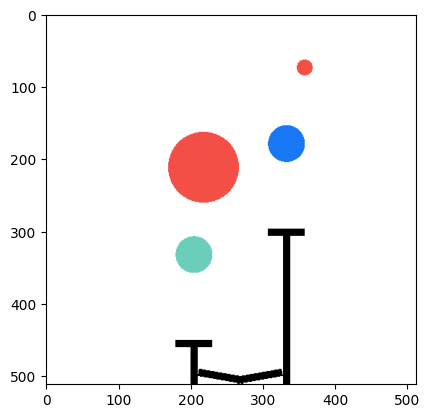

In [12]:
frames = phyre.observations_to_uint8_rgb(batched_imgs[0])
frames = frames[::-1, ::-1]
# print(frames.shape)
first_frame = frames[0]
last_frame = frames[-1]
plt.imshow(frames[0])

In [15]:
# print(states)
action = states['actions'][0]
# initial_state = states['initial_objects'][0]
initial_state = states['objects'][0][0]
final_state = states['objects'][0][-1]
# print(action.shape, initial_state.shape, final_state.shape)
# print(initial_state)
# print(final_state)

def add_action_to_first_state(first_state, action):
    states = [first_state]
    new_state = np.zeros((1, 14))
    new_state[:, [0,1,3]] = action[:3]
    new_state[:, [4,8]] = 1
    states.append(new_state)
    if action.shape[-1] > 3:
        new_state = np.zeros((1, 14))
        new_state[:, [0,1,3]] = action[3:]
        new_state[:, [4,8]] = 1
        states.append(new_state)
    states = np.vstack(states)
    return states

print(action)
print(initial_state)
print('\n')
print(states['initial_objects'][0])
# print(initial_state[-3:])
# initial_state = add_action_to_first_state(initial_state, action)
# print(initial_state[-5:])


[0.42762047 0.58870272 0.75396565 0.7010873  0.85801239 0.14670313]
[[ 0.40000004  0.3497728   0.          0.09960938  1.          0.
   0.          0.          0.          1.          0.          0.
   0.          0.        ]
 [ 0.65        0.64977276  0.          0.09960938  1.          0.
   0.          0.          0.          0.          1.          0.
   0.          0.        ]
 [ 0.4001953   0.11        0.          0.10198039  0.          1.
   0.          0.          0.          0.          0.          0.
   0.          1.        ]
 [ 0.6501953   0.41000003  0.          0.10198039  0.          1.
   0.          0.          0.          0.          0.          0.
   0.          1.        ]
 [ 0.4001953  -0.40000004  0.25        1.0002      0.          1.
   0.          0.          0.          0.          0.          0.
   0.          1.        ]
 [ 0.6501953  -0.10000001  0.25        1.0002      0.          1.
   0.          0.          0.          0.          0.          0.
   0.

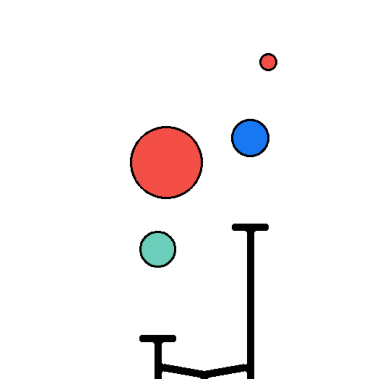

([array([0.69921875, 0.8554368 ], dtype=float32),
  array([0.42578125, 0.58590555], dtype=float32),
  array([0.40000004, 0.3497728 ], dtype=float32),
  array([0.65      , 0.64977276], dtype=float32)],
 [array([0.6982422, 0.8564453], dtype=float32),
  array([0.42285156, 0.58496094], dtype=float32),
  array([0.39941406, 0.35058594], dtype=float32),
  array([0.64941406, 0.6513672 ], dtype=float32)])

In [26]:
import cv2
from phyre.vis import _hex_to_ints

WAD_COLORS = np.array(
    [
        # [255, 255, 255],  # White.
        _hex_to_ints('f34f46'),  # Red.
        _hex_to_ints('6bcebb'),  # Green.
        _hex_to_ints('1877f2'),  # Blue.
        _hex_to_ints('4b4aa4'),  # Purple.
        _hex_to_ints('b9cad2'),  # Gray.
        # [0, 0, 0],  # Black.
        # _hex_to_ints('fcdfe3'),  # Light red.
    ],
    dtype=np.uint8)

COLORS_to_str = {
        # [255, 255, 255] : 'white',  # White.
        _hex_to_ints('f34f46') : 'red',  # Red.
        _hex_to_ints('6bcebb') : 'green',  # Green.
        _hex_to_ints('1877f2') : 'blue',  # Blue.
        _hex_to_ints('4b4aa4'): 'purple',  # Purple.
        _hex_to_ints('b9cad2'): 'gray',  # Gray.
        # [0, 0, 0]: 'black',  # Black.
        # _hex_to_ints('fcdfe3') : 'light_red',  # Light red.
}

color_str_index = {
    'red': 8,
    'green': 9,
    'blue': 10,
    'purple': 11,
    'gray': 12,
}

WIDTH = 512


def normalized_positions(xy):
    xy[0] = xy[0] / WIDTH
    xy[1] = 1 - xy[1] / WIDTH
    return xy


# Now we need a function to find objects of a particular color
def find_objects_of_color(image_rgb, color, color_tol=50):
    # Convert color and color_tol to int to prevent overflow
    color = np.array(color, dtype=np.int32)

    # Calculate min and max color values
    min_color = np.clip(color - color_tol, 0, 255)
    max_color = np.clip(color + color_tol, 0, 255)

    # Convert back to uint8
    min_color = np.array(min_color, dtype=np.uint8)
    max_color = np.array(max_color, dtype=np.uint8)
    # print(min_color, max_color)
    mask = cv2.inRange(image_rgb, min_color, max_color)
    return mask

# Helper function to find circles with Hough Transform
def find_circles(mask, dp, minDist, param1, param2, minRadius, maxRadius):
    return cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT, dp, minDist,
                            param1=param1, param2=param2,
                            minRadius=minRadius, maxRadius=maxRadius)

def is_valid_circle(circle, color_mask):
    # Create a mask for the circle
    circle_img = np.zeros_like(color_mask)
    cv2.circle(circle_img, (int(circle[0]), int(circle[1])), int(circle[2]), (255, 255, 255), -1)

    # Perform bitwise AND to find the colored area within the circle
    colored_area = cv2.bitwise_and(color_mask, color_mask, mask=circle_img)

    # Calculate the area ratio
    circle_area = np.pi * (circle[2] ** 2)
    colored_area_count = np.count_nonzero(colored_area)
    area_ratio = colored_area_count / circle_area

    # Set a threshold for the minimum area ratio for a circle to be considered valid
    area_ratio_threshold = 0.85  # This threshold may need to be adjusted
    # print(area_ratio)

    return area_ratio > area_ratio_threshold

def filter_circles(circles, color_mask):
    # Sort the circles based on their radius, largest first
    circles = sorted(circles, key=lambda x: x[2], reverse=True)
    
    # Filter out circles based on the area ratio of colored pixels
    circles = [circle for circle in circles if is_valid_circle( circle, color_mask)]
    
    filtered_circles = []
    
    for circle in circles:
        center, radius = circle[:2], circle[2]
        # # Check if this circle is inside any already accepted larger circle
        if not any(np.linalg.norm(np.array(center) - np.array(other_center)) < other_radius 
                   for other_center, other_radius in filtered_circles):
            filtered_circles.append((center, radius))
    
    return filtered_circles

def fill_missing_values(list_a, list_b):
    # Make sure all elements are numpy arrays
    
    # Initialize the result list with NaN vectors of the same dimension as list_b's elements
    result = [np.full_like(list_b[0], np.nan) for _ in range(len(list_b))]
    
    # Iterate through each element in list_a
    for idx_a, elem_a in enumerate(list_a):
        # Calculate the distance between elem_a and each element in list_b
        distances = [np.linalg.norm(elem_a - elem_b) for elem_b in list_b]
        # Find the index of the closest element in list_b
        idx_b = np.argmin(distances)
        # Place elem_a in the result list at the position of the closest element
        result[idx_b] = elem_a
    
    return result

def parse_state_from_image(image_rgb, gt_state, filter_stick=True):
    image_copy = image_rgb.copy()
    
    # image_copy = cv2.GaussianBlur(image_copy, (3, 3), 0)
    image_copy = cv2.medianBlur(image_copy, 5)
    image_gray = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)

    # Store all circles in a list
    all_circles = {}
    circles = find_circles(image_gray, dp=1.0, minDist=10, param1=50, param2=15, minRadius=10, maxRadius=100)
    
    all_gt_states = []
    all_rollout_states = []
    
    if filter_stick:
        object_indices = (gt_state[:, 5] == 0) & ((gt_state[:, 4] == 0) | (gt_state[:, -1] == 0))
        gt_state = gt_state[object_indices]
    
    # Go through all the colors in the WAD_COLORS array except for black and white
    for color, color_name in COLORS_to_str.items():  # Skipping white
        color_index = color_str_index[color_name]
        # For circles
        circle_mask = find_objects_of_color(image_copy, color)
        
        filtered_circles = []
        if circles is not None:
            # print(circles[0])
            # Filter out circles
            filtered_circles = filter_circles(circles[0], circle_mask)
            all_circles[color_name] = filtered_circles
            # print(filtered_circles, '\n')
    
        color_balls = []
        for object_state in gt_state:
            if object_state[4] == 1: # is ball
                if object_state[color_index] == 1: # is current color
                    color_balls.append(object_state)
        if len(color_balls) > 0:
            color_balls.sort(key=lambda x: x[3])
            filtered_circles.sort(key=lambda x: x[1])
            color_balls = [x[:2] for x in color_balls]
            filtered_circles = [normalized_positions(x[0]) for x in filtered_circles]
            
            # fill missing values of undetected balls
            if len(filtered_circles) < len(color_balls):
                filtered_circles = fill_missing_values(filtered_circles, color_balls)
                
            all_gt_states.extend(color_balls)
            all_rollout_states.extend(filtered_circles)
            
            # print(color_name)
            # print(color_balls)
            # print(filtered_circles)
    return all_gt_states, all_rollout_states
        

def visualize_all_objects(image_rgb):
    # Copy of the image for drawing
    image_copy = image_rgb.copy()
    
    # image_copy = cv2.GaussianBlur(image_copy, (3, 3), 0)
    image_copy = cv2.medianBlur(image_copy, 5)
    image_gray = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)

    # Store all circles in a list
    all_circles = []
    circles = find_circles(image_gray, dp=1.0, minDist=10, param1=50, param2=15, minRadius=10, maxRadius=100)
    # print(circles[0])

    # Go through all the colors in the WAD_COLORS array except for black and white
    for color, color_name in COLORS_to_str.items():  # Skipping white
        # print(color_name)
        # For circles
        # plt.imshow(circle_mask)
        # plt.axis('off') # Hide axis
        # plt.show()
        circle_mask = find_objects_of_color(image_copy, color)
        
        if circles is not None:
            filtered_circles = filter_circles(circles[0], circle_mask)
            all_circles.extend(filtered_circles)
            # print(filtered_circles, '\n')

    # Draw the filtered circles
    for center, radius in all_circles:
        cv2.circle(image_copy, tuple(np.int0(center)), int(radius), 
                   (0, 0, 0), 2)
    
    return image_copy


# Visualize all objects in the original image
visualized_all_objects = visualize_all_objects(first_frame)

# Display the result
plt.imshow(visualized_all_objects)
plt.axis('off') # Hide axis
plt.show()

parse_state_from_image(first_frame, initial_state)



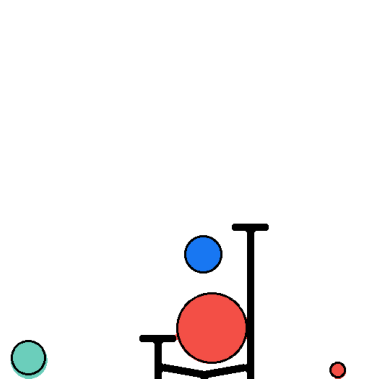

([array([0.887399  , 0.02156319], dtype=float32),
  array([0.5444782 , 0.13655889], dtype=float32),
  array([0.0512654 , 0.05047716], dtype=float32),
  array([0.5228375 , 0.33610716], dtype=float32)],
 [array([0.8857422 , 0.02441406], dtype=float32),
  array([0.54589844, 0.13769531], dtype=float32),
  array([0.04980469, 0.05761719], dtype=float32),
  array([0.52246094, 0.33691406], dtype=float32)])

In [27]:
visualized_all_objects = visualize_all_objects(last_frame)
plt.imshow(visualized_all_objects)
plt.axis('off') # Hide axis
plt.show()

parse_state_from_image(last_frame, final_state)


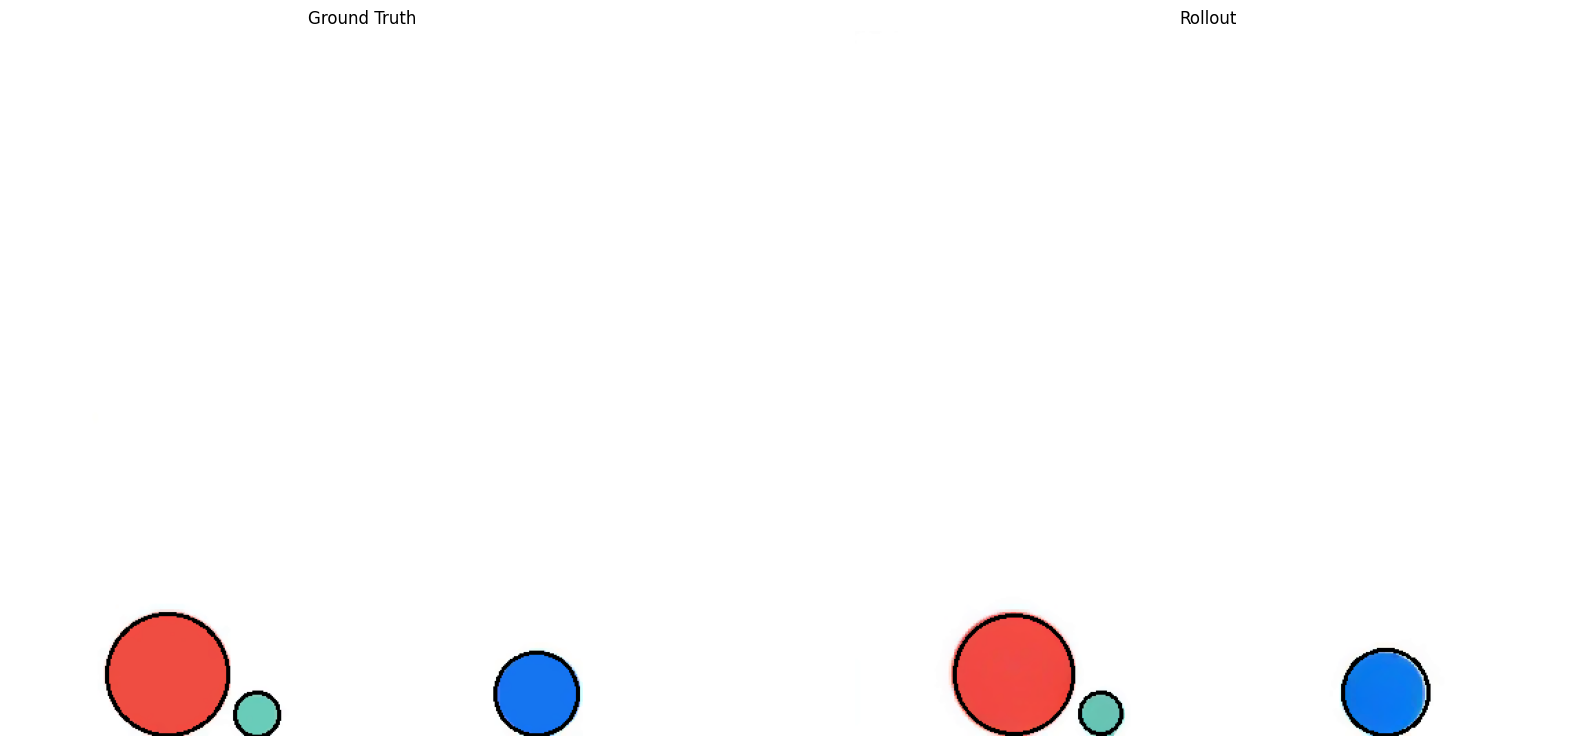

In [21]:
import cv2
import pathlib

def get_gt_and_rollout_videos(video_path):
    # Capture video from file
    cap = cv2.VideoCapture(video_path)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Split the frame into three parts
        frame1 = frame[:, :256, :]
        frame2 = frame[:, 256:512, :]
        frame3 = frame[:, 512:, :]

    # Resize frames
    resized_frame1 = cv2.resize(frame1, (512, 512), interpolation=cv2.INTER_AREA)
    resized_frame3 = cv2.resize(frame3, (512, 512), interpolation=cv2.INTER_AREA)

    # Release the video capture/writer
    cap.release()

    # Return the paths to the videos
    return resized_frame1, resized_frame3


# Call the function with the uploaded video
for video_path in list(pathlib.Path('300k_samples').glob('*.mp4'))[:1]:
    gt_video_frame, rollout_video_frame = get_gt_and_rollout_videos(str(video_path))
    gt_video_frame = cv2.cvtColor(gt_video_frame, cv2.COLOR_BGR2RGB)
    rollout_video_frame = cv2.cvtColor(rollout_video_frame, cv2.COLOR_BGR2RGB)

    
    # Create a figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))  # 1 row, 2 columns

    # Subfigure 1: Ground truth video frame visualization
    visualized_gt = visualize_all_objects(gt_video_frame)
    ax1.imshow(visualized_gt)
    ax1.axis('off')  # Removes the axis
    ax1.set_title('Ground Truth')

    # Subfigure 2: Rollout video frame visualization
    visualized_rollout = visualize_all_objects(rollout_video_frame)
    ax2.imshow(visualized_rollout)
    ax2.axis('off')  # Removes the axis
    ax2.set_title('Rollout')

    # Display the figure with subfigures
    plt.show()

In [52]:
import h5py
import numpy as np
import imageio
import tempfile
import imageio.v3 as iio # need python at least 3.9
from pathlib import Path
import time
from io import BytesIO

def L2_metrics(list_a, list_b):
    distances = []
    for elem_a, elem_b in zip(list_a, list_b):
        # Check if elem_a is not NaN. Since elem_a is a vector, we need to check if any of its values are NaN.
        if not np.any(np.isnan(elem_a)) and not np.any(np.isnan(elem_b)):
            # Calculate the L2 distance for non-NaN elements
            distance = np.linalg.norm(elem_a - elem_b)
            distances.append(distance)
    # no ball is detected
    average_distance = np.mean(distances) if distances else np.nan
    # normalized to [0, 100]
    average_distance = average_distance / np.sqrt(2) * 100
    return average_distance

def get_last_ema(values_list, span):
    # Convert the list to a pandas Series
    series = pd.Series(values_list)
    # Calculate the EMA with specified span
    ema = series.ewm(span=span, adjust=False).mean()
    # Return the last EMA value
    return ema.iloc[-1]

def evaluate(rollout_frames, gt_features, mode, gamma=0.98, sample_freq=5):
    """set large sample_freq to save computational cost"""
    assert len(rollout_frames) == len(gt_features)
    if mode == 'last':
        gt_state, rollout_state = parse_state_from_image(rollout_frames[-1], gt_features[-1])
        # print('gt     : ', gt_state)
        # print('rollout: ', rollout_state)
        ssd = L2_metrics(gt_state, rollout_state)
        return ssd
        
    if mode == 'average':
        ssd_list = []
        for rollout_frame, gt_feature in zip(rollout_frames[sample_freq-1::sample_freq], gt_features[sample_freq-1::sample_freq]):
            gt_state, rollout_state = parse_state_from_image(rollout_frame, gt_feature)
            ssd = L2_metrics(gt_state, rollout_state)
            ssd_list.append(ssd)
        print(ssd_list)
        span = len(rollout_frames[sample_freq-1::sample_freq])
        ema_ssd = get_last_ema(ssd_list, span=span)
        return ema_ssd


def read_gt_features(hdf5_path, trial_index):
    hdf = h5py.File(hdf5_path, 'r')
    objects = hdf['object_streams'][trial_index]
    return objects
    
    
def decode_hdf5_to_frames_wo_disk(hdf5_path, trial_index, format_hint='.mp4'):
    """Decode video frames from a byte stream stored in an HDF5 file directly in memory."""
    hdf = h5py.File(hdf5_path, 'r')

    byte_stream = hdf['video_streams'][trial_index]
    byte_obj = byte_stream.tobytes()
    # Decode frames directly from byte stream
    frames = iio.imread(byte_obj, index=None, extension=format_hint)
    imageio.mimsave('deocded_v2.mp4', frames, fps=5)
    action = hdf['action_streams'][trial_index]
    return frames, action

tiral_index = 9

for hdf5_path in list(pathlib.Path('../phyre_data_10_v4').glob('00023:*.hdf5')):
    print(hdf5_path)
    gt_frames, _ = decode_hdf5_to_frames_wo_disk(hdf5_path, tiral_index)
    gt_features = read_gt_features(hdf5_path, tiral_index)
    # print(gt_frames.shape, gt_features.shape)
    ssd = evaluate(gt_frames, gt_features, mode='last')
    print(ssd)
    ssd = evaluate(gt_frames, gt_features, mode='average')
    print(ssd)

../phyre_data_10_v4/00023:008.hdf5
0.13646977503074775


[0.13765805274095178, 0.0723735392871135, 0.16440186625057765, 0.1342146799130308, 0.17596714258170668, 0.19552795595676817, 0.17786608859770023, 0.16641860941543662, 0.15932468565738328, 0.13646977503074775]
0.15406059790564114
../phyre_data_10_v4/00023:017.hdf5
0.22824056170075258
[0.16946704487011405, 0.1031903517969363, 0.10185325125973453, 0.13203521863205564, 0.17866646712908973, 0.20884700216710597, 0.10456674274584557, 0.22824056170075258, 0.22824056170075258, 0.22824056170075258]
0.18592980566355696
../phyre_data_10_v4/00023:031.hdf5
0.1944516802037593
[0.1612402105313653, 0.10677441442718144, 0.1842627125034761, 0.17011739049897237, 0.22229537005519887, 0.16248525477815745, 0.20771277449739464, 0.17853340821125183, 0.1944516802037593, 0.1944516802037593]
0.18264641380554805
../phyre_data_10_v4/00023:064.hdf5
0.11177405140456084
[0.11553611038350738, 0.14582030855888645, 0.14169202474724438, 0.15893731331417513, 0.16440619618071764, 0.09530813379921493, 0.14867822708740444, 0.

KeyboardInterrupt: 